# Analysis of the Area of the bounding boxes
## Bounding boxes too small or too large can't be an helipad

In [4]:
import os
import json

In [26]:
index_path = "../helipad_path_over_0_m10.txt"
meta_folder = "C:\\Users\\AISG\\Documents\\Jonas\\Real_World_Dataset_TMS_meta\\sat\\"
bounding_boxes_groundtruth_path = "C:\\Users\\AISG\\Documents\\Jonas\\Helipad\\Real_World_Detected_Boxes\\model_10_0.0_groundtruth\\"
model_number = 10

In [67]:
def filter_by_area(bb_image_path, meta_folder, model_number, lower=200, higher=600):
    bb_image_name = os.path.splitext(os.path.basename(bb_image_path))[0]
    image_info = bb_image_name.split('_')
    zoom = image_info[1]
    xtile = image_info[2]
    ytile = image_info[3]
    
    meta_path = os.path.join(meta_folder, zoom, xtile, f"Satellite_{zoom}_{xtile}_{ytile}.meta")
    
    if not os.path.isfile(meta_path):
        print("Meta File does not exist")
        return -1
    
    with open(meta_path, 'r') as j:
        meta = json.load(j)
    j.close()
    bounds = meta["predicted"]["model_{}".format(model_number)]["coordinates"]["bounds"]
    l = compute_distance_between_two_gps_points(bounds[0][0], bounds[0][1])
    L = compute_distance_between_two_gps_points(bounds[0][0], bounds[0][2])
    area = l*L

    if area<lower or area>higher:
        return 0
    else:
        return 1

def compute_distance_between_two_gps_points(point_1, point_2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(point_1[0])
    lon1 = radians(point_1[1])
    lat2 = radians(point_2[0])
    lon2 = radians(point_2[1])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c * 1000
    
    return distance

def find_groundtruth_from_name(meta_filename, bb_groundtruth_path):
    helipad_filenames = os.listdir(os.path.join(bb_groundtruth_path, 'helipad'))
    fp_filenames = os.listdir(os.path.join(bb_groundtruth_path, 'false_positive'))
    meta_info = meta_filename.split('.')[0]
    for filename in helipad_filenames:
        image_name = "_".join(filename.split('_')[:4])
        if image_name == meta_info:
            return 'helipad'
    
    for filename in fp_filenames:
        image_name = "_".join(filename.split('_')[:4])
        if image_name == meta_info:
            return 'false_positive'

In [69]:
def benchmark_area_filter(bb_groundtruth_path, meta_folder, model_number=10, lower=200, higher=600):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    for subdir, dirs, files in os.walk(os.path.join(bb_groundtruth_path, 'helipad'), topdown=True):
        for file in files:
            image_path = os.path.join(subdir, file)
            res = filter_by_area(image_path, meta_folder, model_number, lower=lower, higher=higher)
            if res == 1:
                TP += 1
            elif res == 0:
                FN += 1
    
    for subdir, dirs, files in os.walk(os.path.join(bb_groundtruth_path, 'false_positive'), topdown=True):
        for file in files:
            image_path = os.path.join(subdir, file)
            res = filter_by_area(image_path, meta_folder, model_number, lower=lower, higher=higher)
            if res == 1:
                FP += 1
            elif res == 0:
                TN += 1
        
    return {'TP': TP, 
            'TN': TN,
            'FP': FP,
            'FN': FN}

In [74]:
res = benchmark_area_filter(bounding_boxes_groundtruth_path, meta_folder, model_number=10, lower=200, higher=600)

In [75]:
res

{'TP': 55, 'TN': 189, 'FP': 311, 'FN': 11}

In [80]:
helipad_area = []
fp_area = []
fp_scores = []
helipad_scores = []

with open(index_path, 'r') as f:
    lines = f.readlines()
    for line in lines:
#         print(line)
        groundtruth = find_groundtruth_from_name(line, bounding_boxes_groundtruth_path)
#         print(groundtruth)
        if groundtruth == None:
            continue
        info = line.split('_')
        zoom = info[1]
        xtile = info[2]
        ytile = info[3]
        if line[len(line)-1] == '\n':
            line = line[:len(line)-1]
        meta_path = os.path.join(meta_folder, zoom, xtile, line)
        with open(meta_path, 'r') as j:
            meta = json.load(j)
        j.close()
        bounds = meta["predicted"]["model_{}".format(model_number)]["coordinates"]["bounds"]
        scores = meta["predicted"]["model_{}".format(model_number)]["score"]
        l = compute_distance_between_two_gps_points(bounds[0][0], bounds[0][1])
        L = compute_distance_between_two_gps_points(bounds[0][0], bounds[0][2])
        area = l*L
        if groundtruth == 'helipad':
            helipad_area.append(area)
            helipad_scores.extend(scores)
        elif groundtruth == 'false_positive':
            fp_area.append(area)
            fp_scores.extend(scores)
#         print(distance)
#         print()

In [81]:
helipad_scores

[0.9943981766700745,
 0.9930108189582825,
 0.9942004680633545,
 0.9928762912750244,
 0.9920681715011597,
 0.9549533128738403,
 0.9352958798408508,
 0.7062541246414185,
 0.9962766766548157,
 0.9941400289535522,
 0.9939061999320984,
 0.9961036443710327,
 0.9953881502151489,
 0.9940647482872009,
 0.9934049248695374,
 0.9923071265220642,
 0.8365017175674438,
 0.9844106435775757,
 0.9797859787940979,
 0.9925674200057983,
 0.9948082566261292,
 0.9938054084777832,
 0.9944095015525818,
 0.9901868104934692,
 0.9731014966964722,
 0.9914231896400452,
 0.9380130767822266,
 0.9891985058784485,
 0.9928027987480164,
 0.9937343001365662,
 0.7815778851509094,
 0.9591673612594604,
 0.9954571723937988,
 0.9879364371299744,
 0.9899671077728271,
 0.7436666488647461,
 0.9834119081497192,
 0.9851915836334229,
 0.9925301671028137,
 0.7315884232521057,
 0.7842870950698853,
 0.9905351996421814,
 0.9904230833053589,
 0.9891154766082764,
 0.8577209711074829,
 0.9725331664085388,
 0.7633795142173767,
 0.9942540526

(array([ 2.,  2.,  2.,  1.,  1.,  0.,  1.,  2.,  0.,  0.,  1.,  5.,  4.,
         6., 56.]),
 array([0.70625412, 0.72558896, 0.7449238 , 0.76425864, 0.78359347,
        0.80292831, 0.82226315, 0.84159798, 0.86093282, 0.88026766,
        0.89960249, 0.91893733, 0.93827217, 0.957607  , 0.97694184,
        0.99627668]),
 <a list of 15 Patch objects>)

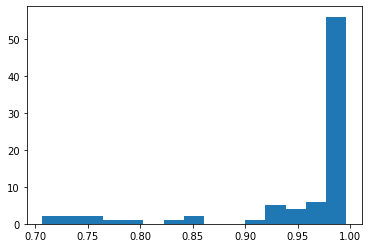

In [85]:
plt.hist(helipad_scores, bins=15)

(array([ 18.,   6.,  14.,  15.,  21.,  19.,  20.,  13.,  27.,  22.,  20.,
         30.,  49.,  68., 179.]),
 array([0.70392275, 0.72330853, 0.74269431, 0.7620801 , 0.78146588,
        0.80085166, 0.82023745, 0.83962323, 0.85900901, 0.87839479,
        0.89778058, 0.91716636, 0.93655214, 0.95593793, 0.97532371,
        0.99470949]),
 <a list of 15 Patch objects>)

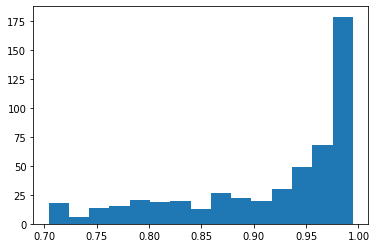

In [86]:
plt.hist(fp_scores, bins=15)

In [82]:
fp_scores

[0.7950887680053711,
 0.7538143992424011,
 0.9931216835975647,
 0.7685009837150574,
 0.9036515355110168,
 0.9081724286079407,
 0.9540883302688599,
 0.8345561623573303,
 0.9668570160865784,
 0.7087214589118958,
 0.9889504313468933,
 0.926888644695282,
 0.9896115064620972,
 0.8250635266304016,
 0.7890599966049194,
 0.8914943337440491,
 0.7839738726615906,
 0.9076822400093079,
 0.8917868137359619,
 0.8578156232833862,
 0.9736930131912231,
 0.7633040547370911,
 0.9809541702270508,
 0.9931025505065918,
 0.9450364112854004,
 0.9266798496246338,
 0.8699710369110107,
 0.9824475646018982,
 0.9767122864723206,
 0.9941501617431641,
 0.9249107837677002,
 0.8496803045272827,
 0.8235066533088684,
 0.8651293516159058,
 0.9900155663490295,
 0.9029337167739868,
 0.8156177997589111,
 0.9875520467758179,
 0.9914743900299072,
 0.9480203986167908,
 0.8868976831436157,
 0.9252243041992188,
 0.7039227485656738,
 0.792855978012085,
 0.7602925896644592,
 0.8169746994972229,
 0.9874899983406067,
 0.716887891292

In [58]:
helipad_area

[450.69505042537355,
 238.2765048191747,
 171.19854485615258,
 238.6090537854162,
 208.5779553334986,
 234.2718494538594,
 261.55206038636055,
 204.4062812548677,
 367.7591347639765,
 401.3934148132812,
 284.70676128291245,
 583.2235026097313,
 326.1279209709333,
 540.0444127158286,
 172.1157885535318,
 467.8572839353098,
 546.8902273602031,
 500.70201955466393,
 465.9506712493636,
 260.5653228820725,
 325.40087020177924,
 289.83813002008,
 126.05546404595341,
 191.3409958091747,
 487.89232263509115,
 320.26724477198826,
 623.4956549675103,
 499.4460981614726,
 314.4901545003747,
 501.20867009324314,
 216.8846322537857,
 192.19426494168945,
 216.6305477642604,
 192.10608234764297,
 256.80760211956596,
 276.00982907665446,
 357.99706647315645,
 374.4466665294576,
 546.761880014239,
 208.21942474575133,
 294.9534526760642,
 475.30103150667975,
 493.915967650289,
 636.513013880818,
 218.31787762775528,
 218.3168830397776,
 808.3070935450444,
 335.9504496475274,
 438.1552607709823,
 594.17

In [53]:
import matplotlib.pyplot as plt

(array([ 0.,  1.,  5., 10.,  8., 11.,  7.,  3.,  7.,  7.,  2.,  2.,  0.,
         1.,  0.,  1.,  1.,  0.,  0.]),
 array([   0,  100,  150,  200,  250,  300,  350,  400,  450,  500,  550,
         600,  650,  700,  750,  800,  850,  900,  950, 1000]),
 <a list of 19 Patch objects>)

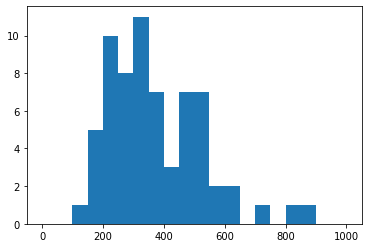

In [65]:
plt.hist(helipad_area, bins=[0, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000])

(array([ 2.,  3., 16., 32., 47., 56., 43., 46., 22., 35., 29., 29., 30.,
        17., 13., 19., 16.,  7.,  6.]),
 array([   0,  100,  150,  200,  250,  300,  350,  400,  450,  500,  550,
         600,  650,  700,  750,  800,  850,  900,  950, 1000]),
 <a list of 19 Patch objects>)

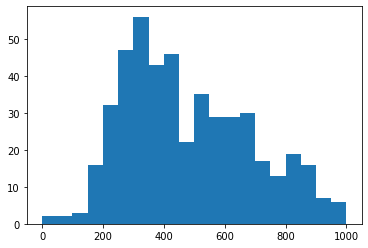

In [64]:
plt.hist(fp_area, bins=[0, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000])

In [45]:
fp_area

[413.9506272096352,
 101.50333369933398,
 1333.6241207150804,
 1189.3132407878068,
 599.5742912793298,
 265.7174252156287,
 682.9167187186523,
 751.3834696512167,
 846.197880822744,
 665.5693395678217,
 675.4861812266217,
 1082.5593156100242,
 630.9556270108291,
 530.7804015685725,
 526.9281750413659,
 272.18868270058584,
 1112.5316747259258,
 305.24805498006594,
 189.99765590649002,
 648.6013632402564,
 429.48799128274345,
 868.0440445466357,
 507.5771750643297,
 628.3469381392377,
 54.21047238220787,
 835.0048349573939,
 60.467673609292824,
 426.63186677771876,
 591.4162715452355,
 347.3089655381907,
 831.1248187956008,
 1018.4177042377678,
 347.451560689879,
 330.6622870599956,
 419.57775130870624,
 326.090878219981,
 438.8322072429726,
 745.0834398019169,
 748.5021225555851,
 326.0733638271527,
 774.7887778559866,
 654.0352649825181,
 315.6037199161314,
 841.6501704397995,
 243.13779705341042,
 242.10682514318162,
 385.7925141392108,
 424.3551726788541,
 391.7775605738572,
 736.418